In [187]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
from tqdm import tqdm

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
import torchvision
from hyperdash import monitor_cell

In [188]:
# Setup seeds
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [189]:
class Generator(nn.Module):
    def __init__(self, z_dim=256):
        super(Generator, self).__init__()
        self.output_bias = nn.Parameter(torch.zeros(3, 32, 32), requires_grad=True)
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=256,
                               kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128,
                               kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32,
                               kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True))

        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32,
                               kernel_size=5, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True))

        self.layer6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32,
                               kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=3,
                               kernel_size=1, stride=1, bias=False)
        )

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.last(out)
        out = F.sigmoid(out + self.output_bias)
        return out

In [190]:
#モデル構造確認
Generator()

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.

torch.Size([100, 3, 32, 32])


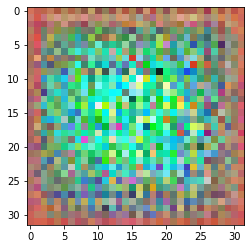

In [191]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

latent_size=256
batch_size=100

G = Generator(z_dim=latent_size)
input_z = torch.randn(batch_size, latent_size, 1, 1)
print(G(input_z).size())
fake_images = G(input_z)
img_transformed = fake_images[0].detach().numpy().transpose(1, 2, 0)
plt.imshow(img_transformed)
plt.show();

In [192]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=256):
        super(Discriminator, self).__init__()

        self.x_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        
        self.x_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        
        self.x_layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        
        self.x_layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        
        self.z_layer1 = nn.Sequential(
            nn.Conv2d(z_dim, 512, kernel_size=1, stride=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        
        self.z_layer2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )

        # 最後の判定
        self.last1 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )

        self.last2 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=1, stride=1, bias=True),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
        )
        
        self.last3 = nn.Conv2d(1024, 1, kernel_size=1, stride=1, bias=True)

    def forward(self, x, z):

        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        x_out = self.x_layer3(x_out)
        x_out = self.x_layer4(x_out)
        x_out = self.x_layer5(x_out)

        z_out = self.z_layer1(z)
        z_out = self.z_layer2(z_out)

        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        out = self.last2(out)

        feature = out
        feature = feature.view(feature.size()[0], -1)
        out = self.last3(out)

        return out, feature

In [193]:
#モデル構造確認
D = Discriminator()
D

Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
  )
  (x_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (x_layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (x_layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace

In [194]:
D = Discriminator(z_dim=256)

input_z = torch.randn(batch_size, latent_size, 1, 1)
fake_images = G(input_z)

d_out, feature = D(fake_images, input_z)
print(nn.Sigmoid()(d_out))
print(feature.size())

tensor([[[[0.5072]]],


        [[[0.4958]]],


        [[[0.5027]]],


        [[[0.4964]]],


        [[[0.4976]]],


        [[[0.5200]]],


        [[[0.5333]]],


        [[[0.5050]]],


        [[[0.4976]]],


        [[[0.4933]]],


        [[[0.5307]]],


        [[[0.5133]]],


        [[[0.5090]]],


        [[[0.5150]]],


        [[[0.5071]]],


        [[[0.4742]]],


        [[[0.5133]]],


        [[[0.5009]]],


        [[[0.5197]]],


        [[[0.4999]]],


        [[[0.4790]]],


        [[[0.4921]]],


        [[[0.5199]]],


        [[[0.4895]]],


        [[[0.5066]]],


        [[[0.5022]]],


        [[[0.5254]]],


        [[[0.4712]]],


        [[[0.5036]]],


        [[[0.5038]]],


        [[[0.5212]]],


        [[[0.5079]]],


        [[[0.5190]]],


        [[[0.5005]]],


        [[[0.4948]]],


        [[[0.4931]]],


        [[[0.5116]]],


        [[[0.5148]]],


        [[[0.5021]]],


        [[[0.5013]]],


        [[[0.5109]]],


        [[[0.492

In [195]:
class Encoder(nn.Module):

    #noiseについては新しく足した.
    def __init__(self, z_dim=256, noise=False):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        
        if noise:
            self.z_dim *= 2
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True))

        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.Conv2d(512, self.z_dim, kernel_size=1, stride=1, bias=True)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.last(out)
        #out = torch.squeeze(self.last(out))

        return out
    #, x3.view(batch_size, -1), x2.view(batch_size, -1), x1.view(batch_size, -1)

In [196]:
Encoder()

Encoder(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (layer5): Sequent

In [197]:
E = Encoder(z_dim=256)
x = fake_images
z = E(x)
print(z.shape)

torch.Size([100, 256, 1, 1])


In [198]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        m.bias.data.fill_(0)
        
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [199]:
torch.full((10,), 0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [236]:
# モデルを学習させる関数を作成


def train_model(G, D, E, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    lr_ge = 1e-4
    lr_d = 1e-4 #もとはdevided by 4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 誤差関数を定義
    # BCEWithLogitsLossは入力にシグモイド（logit）をかけてから、
    # バイナリークロスエントロピーを計算
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 256
    mini_batch_size = 50

    # ネットワークをGPUへ
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    E.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_e_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges[0].size()[0] == 1:
                continue

            # ミニバッチサイズの1もしくは0のラベル役のテンソルを作成
            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges[0].size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPUが使えるならGPUにデータを送る
            imges = imges[0].to(device)

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # 真の画像を判定　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim, 1, 1).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            #d_optimizer.zero_grad()
            #d_loss.backward()
            #d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim, 1, 1).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)
            
            #print(g_loss)
            if g_loss.item() < 3.5:
                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()
            # バックプロパゲーション
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoderの学習
            # --------------------
            # 真の画像のzを推定
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 誤差を計算
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # バックプロパゲーション
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("総イテレーション回数:", iteration)

    return G, D, E


In [237]:
def indices_maker():
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215841, 0.44653091),
                             (0.24703223, 0.24348513, 0.26158784))]
    )
    trainset = torchvision.datasets.CIFAR10(root="./data",
                                            train=True, download=True,
                                            transform=transform)
    aircraft_indices, car_indices, bird_indices, cat_indices, deer_indices = [], [], [], [], []
    dog_indices, frog_indices, horse_indices, ship_indices, truck_indices = [], [], [], [], []
    i = 0
    #aircraft_indicesにlabelが0(=飛行機)の画像のindexを入れる.
    for tensor in tqdm(trainset):
        if tensor[1] == 0:
            aircraft_indices.append(i)
        if tensor[1] == 1:
            car_indices.append(i)
        if tensor[1] == 2:
            bird_indices.append(i)
        if tensor[1] == 3:
            cat_indices.append(i)
        if tensor[1] == 4:
            deer_indices.append(i)
        if tensor[1] == 5:
            dog_indices.append(i)
        if tensor[1] == 6:
            frog_indices.append(i)
        if tensor[1] == 7:
            horse_indices.append(i)
        if tensor[1] == 8:
            ship_indices.append(i)
        if tensor[1] == 9:
            truck_indices.append(i)
        i += 1
    return aircraft_indices, car_indices, bird_indices, cat_indices, deer_indices, dog_indices, frog_indices, horse_indices, ship_indices, truck_indices

In [238]:
#aircraft_indices, car_indices, bird_indices, cat_indices, deer_indices, dog_indices, frog_indices, horse_indices, ship_indices, truck_indices = indices_maker()

In [239]:
len(car_indices)

5000

In [240]:
def load_datasets():
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.49139968, 0.48215841, 0.44653091),
                             (0.24703223, 0.24348513, 0.26158784))]
    )
    trainset = torchvision.datasets.CIFAR10(root="./data",
                                            train=False, download=True,
                                            transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                              shuffle=True, num_workers=4)
    #train_loader = torch.utils.data.DataLoader(trainset, batch_size=100,
    #                                           sampler=SubsetRandomSampler(car_indices), num_workers=4)
    testset = torchvision.datasets.CIFAR10(root="./data",
                                            train=False, download=True,
                                            transform=transform)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                               shuffle=True, num_workers=4)
    return train_loader, test_loader

In [241]:
train_loader, test_loader = load_datasets()

Files already downloaded and verified
Files already downloaded and verified


In [242]:
#動作の確認
batch_iterator = iter(train_loader)
imges = next(batch_iterator)

In [243]:
# 学習・検証を実行する
# 1500epochで150分ほどかかる(200images for mnistで)
# 今回は300程度に制限する. (学習させすぎて収束しすぎてしまったのではないか?) -> 
num_epochs = 100
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_loader, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 0/100
-------------
（train）


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
#作成したモデルの保存(model dirは予め作っておく)
torch.save(G_update.state_dict(), "./model/G_deep_1118.pkl")
torch.save(D_update.state_dict(), "./model/D_deep_1118.pkl")
torch.save(E_update.state_dict(), "./model/E_deep_1118.pkl")

In [147]:
#作成したモデルの読み込み(test ver.)
Disc = Discriminator()
Gene = Generator()
Enc = Encoder()
param_d = torch.load("./model/D.pkl")
param_g = torch.load("./model/G.pkl")
param_e = torch.load("./model/E.pkl")
Disc.load_state_dict(param_d)
Gene.load_state_dict(param_g)
Enc.load_state_dict(param_e)

<All keys matched successfully>

In [93]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)
    
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = torch.sum(loss_each)
    return total_loss, loss_each, residual_loss, discrimination_loss

In [94]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six.moves import cPickle as pickle
from six.moves import xrange  # pylint: disable=redefined-builtin
import collections
import os
import sys
import tarfile
import numpy as np
from tqdm import tqdm
from absl import flags
import absl.logging as _logging  # pylint: disable=unused-import
import scipy.io
import tensorflow as tf
from randaugment import policies as found_policies
from randaugment import augmentation_transforms
#特に異常検知の文脈において.
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
import numpy as np
from tqdm import tqdm
import os
import pickle
import statistics
import matplotlib.pyplot as plt
import random
import warnings
from PIL import Image
warnings.simplefilter('ignore')
from hyperdash import monitor_cell

In [95]:
CIFAR_TARNAME = "cifar-10-python.tar.gz"
CIFAR_DOWNLOAD_URL = "https://www.cs.toronto.edu/~kriz/" + CIFAR_TARNAME
SVHN_DOWNLOAD_URL = "http://ufldl.stanford.edu/housenumbers/{}_32x32.mat"

DOWNLOAD_DATA_FOLDER = "downloaded_data"
MERGE_DATA_FOLDER = "merged_raw_data"

random_seed = np.random.randint(0, 10000)

In [96]:
def format_sup_filename(split, sup_size=-1):
  if split == "test":
    return "test.tfrecord"
  elif split == "train" or split == "dev":
    if sup_size == -1:
      return "{}-full.tfrecord".format(split, sup_size)
    else:
      return "{}-size_{:d}.tfrecord".format(split, sup_size)

def format_unsup_filename(aug_copy_num):
  return "unsup-{:d}.tfrecord".format(aug_copy_num)


def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list(value)))


def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=list(value)))


def get_raw_data_filenames(split):
    if split == "train":
        return ["data_batch_%d" % i for i in xrange(1, 6)]
    elif split == "test":
      return ["test_batch"]
    else:
        assert False


def read_pickle_from_file(filename):
  with tf.gfile.Open(filename, "rb") as f:
    if sys.version_info >= (3, 0):
      data_dict = pickle.load(f, encoding="bytes")
    else:
      data_dict = pickle.load(f)
  return data_dict


def obtain_tfrecord_writer(out_path, shard_cnt):
  tfrecord_writer = tf.python_io.TFRecordWriter(
      "{}.{:d}".format(out_path, shard_cnt))
  return tfrecord_writer


def save_tfrecord(example_list, out_path, max_shard_size=4096):
  shard_cnt = 0
  shard_size = 0
  record_writer = obtain_tfrecord_writer(out_path, shard_cnt)
  for example in example_list:
    if shard_size >= max_shard_size:
      record_writer.close()
      shard_cnt += 1
      record_writer = obtain_tfrecord_writer(out_path, shard_cnt)
      shard_size = 0
    shard_size += 1
    record_writer.write(example.SerializeToString())
  record_writer.close()
  tf.logging.info("saved {} examples to {}".format(len(example_list), out_path))


def save_merged_data(images, labels, split, merge_folder):
  with tf.gfile.Open(
      os.path.join(merge_folder, "{}_images.npy".format(split)), "wb") as ouf:
    np.save(ouf, images)
  with tf.gfile.Open(
      os.path.join(merge_folder, "{}_labels.npy".format(split)), "wb") as ouf:
    np.save(ouf, labels)

In [97]:
all_exist = True
download_folder = os.path.join(DOWNLOAD_DATA_FOLDER)
merge_folder = os.path.join(MERGE_DATA_FOLDER)
for split in ["train", "test"]:
    for field in ["images", "labels"]:
        if not tf.gfile.Exists(os.path.join(merge_folder, "{}_{}.npy".format(split, field))):
            all_exist = False
if all_exist:
    tf.logging.info("found all merged files")
print('all_exist:' + str(all_exist))
tf.logging.info("downloading dataset")
tf.gfile.MakeDirs(download_folder)
tf.gfile.MakeDirs(merge_folder)

INFO:tensorflow:found all merged files
all_exist:True
INFO:tensorflow:downloading dataset


In [98]:
#if FLAGS.task_name == 'cifar10'以下の話
tf.contrib.learn.datasets.base.maybe_download(
    CIFAR_TARNAME, download_folder, CIFAR_DOWNLOAD_URL)
tarfile.open(os.path.join(download_folder, CIFAR_TARNAME), "r:gz").extractall(download_folder)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please write your own downloading logic.


In [99]:
for split in ["train", "test"]:
    images_list = []
    labels_list = []
    for filename in get_raw_data_filenames(split):
        cur_data = read_pickle_from_file(
            os.path.join(download_folder, "cifar-10-batches-py", filename))
        labels_list += [cur_data[b"labels"]]
        images_list += [cur_data[b"data"]]
    images = np.concatenate(images_list, 0)
    labels = np.concatenate(labels_list, 0)
    images = images.reshape([-1, 3, 32, 32])
    images = images.transpose(0, 2, 3, 1)
    save_merged_data(images, labels, split, merge_folder)

In [100]:
#dataのtrainとtestをそれぞれimagesとlabelsに分けて作る.
def load_dataset():
    data = {}
    merge_folder = os.path.join(MERGE_DATA_FOLDER)
    for split in ["train", "test"]:
        with tf.gfile.Open(
            os.path.join(merge_folder, "{}_images.npy".format(split)), 'rb') as inf:
            images = np.load(inf)
        with tf.gfile.Open(
            os.path.join(merge_folder, "{}_labels.npy".format(split)), 'rb') as inf:
            labels = np.load(inf)
        data[split] = {"images":images, "labels":labels}
    return data

In [101]:
#多分iterableにimageとlabelを取り出す.最後まで, 可能な限り
def get_data_by_size_lim(images, labels, sup_size, return_rest=False):
    chosen_images = images[:sup_size]
    chosen_labels = labels[:sup_size]
    rest_images = images[sup_size:]
    rest_labels = labels[sup_size:]
    if return_rest:
        return chosen_images, chosen_labels, rest_images, rest_labels

In [102]:
def process_and_save_sup_data(chosen_images, chosen_labels, split, sup_size=-1):
    chosen_images = chosen_images / 255.0
    mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
    chosen_images = (chosen_images - mean) / std
    example_list = []
    for image, label in zip(chosen_images, chosen_labels):
        example = tf.train.Example(features=tf.train.Features(
            feature={
                "image": _float_feature(image.reshape(-1)),
                "label": _int64_feature(label.reshape(-1))
            }))
        example_list += [example]
    out_path = os.path.join(output_base_dir, format_sup_filename(split, sup_size))
    tf.logging.info(">>saving {} {} examples to {}".format(len(example_list), split, out_path))
    save_tfrecord(example_list, out_path)

In [103]:
def proc_and_dump_sup_data(sub_set_data, split, sup_size=-1):
    images = sub_set_data["images"]
    labels = sub_set_data["labels"]
    if sup_size != -1:
        chosen_images, chosen_labels = get_data_by_size_lim(
            images, labels, sup_size)
    else:
        chosen_images = images
        chosen_labels = labels
    process_and_save_sup_data(chosen_images, chosen_labels, split)

In [106]:
data = load_dataset()
output_base_dir = "data/proc_data/cifar10_eff3"

In [105]:
!mkdir "data/proc_data/cifar10_eff3"

In [108]:
ori_images = data["train"]["images"].copy()
image_idx = np.arange(len(ori_images))
np.random.shuffle(image_idx)
ori_images = ori_images[image_idx]
ori_images = ori_images / 255.0
#平均と標準偏差逐一計算. sklearn
mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
ori_images = (ori_images - mean) / std
aug_policies = found_policies.randaug_policies()
example_list = []
aug_image_list = torch.randn(100, 3, 32, 32)
i = 0
for image in tqdm(ori_images):
    if i < 100:
        chosen_policy = aug_policies[np.random.choice(
            len(aug_policies))]
        #この段階で, chosen_policyは2個の要素を持っている.
        aug_image = augmentation_transforms.apply_policy(
            chosen_policy, image)
        aug_image = augmentation_transforms.cutout_numpy(aug_image)
        #ここで条件式を投げて, aug_imageが一定の閾値以下であれば3回目のaugmentationを加える.
        aug_image_list[i] = torch.from_numpy(aug_image.transpose(2, 0, 1))
        i += 1

INFO:tensorflow:trans_list: ['Invert', 'Cutout', 'Sharpness', 'AutoContrast', 'Posterize', 'ShearX', 'TranslateX', 'TranslateY', 'ShearY', 'Rotate', 'Equalize', 'Contrast', 'Color', 'Solarize', 'Brightness']


100%|██████████| 50000/50000 [00:00<00:00, 330617.33it/s]


In [83]:
aug_image_list.size()

torch.Size([256, 3, 32, 32])

In [225]:
#デバイスの確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス:", device)

使用デバイス: cuda:0


In [226]:
len(aug_image_list[0:257])

100

In [227]:
#ここから下で生成したデータの確認
x = torch.randn(100, 3, 32, 32)
for i in range(100):
    x[i] = torch.from_numpy(images[i].transpose(2,0,1))
x = x.to(device)

z_out_real = E_update(x)
imges_reconstract = G_update(z_out_real)

loss, loss_each, residual_loss_each, discrimination_loss_each = Anomaly_score(x, imges_reconstract, z_out_real, D_update, Lambda=0.1)
loss_each = loss_each.cpu().detach().numpy()
print("total loss:", np.round(loss_each, 0))
print("discrimination loss:", np.round(discrimination_loss_each.cpu().detach().numpy(), 0))
print(np.shape(x[1].cpu().detach().numpy().transpose(1, 2, 0)))
print(np.shape(imges_reconstract[0].cpu().detach().numpy().transpose(1,2,0)))

fig = plt.figure(figsize=(15, 9))
for i in range(0,5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i+50])
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i+50].cpu().detach().numpy().transpose(1,2,0))
    plt.savefig("shippai.png")
"""
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i].cpu().detach().numpy().transpose(1,2,0))"""

RuntimeError: CUDA error: device-side assert triggered

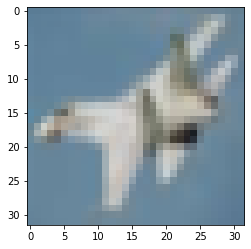

In [103]:
plt.imshow(images[10])
plt.savefig("normal_example.png")

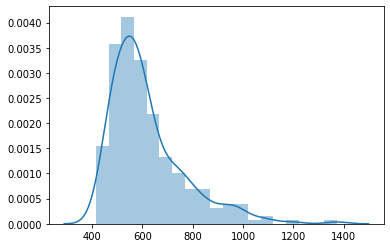

In [89]:
sns.distplot(discrimination_loss_each.cpu().detach().numpy());
#とりあえず閾値を500にしてみる.

In [168]:
tmp[0]

array([51, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


total loss: [2522. 2935. 2644. 2786. 3667. 3389. 2740. 3776. 3233. 2946. 3249. 3207.
 3957. 2660. 2867. 2779. 2981. 2865. 2551. 3142. 3016. 2876. 2605. 3052.
 2652. 5121. 3376. 2567. 2833. 3023. 2774. 3278. 2652. 2312. 3305. 3580.
 4646. 2590. 3274. 2652. 3025. 2756. 2730. 2292. 3357. 2916. 3133. 3608.
 2792. 3361. 3654. 2681. 2536. 3548. 2642. 3642. 3795. 2813. 3186. 2765.
 4401. 2443. 3084. 2673. 2516. 3242. 3296. 3290. 3276. 2992. 3210. 3021.
 3635. 3734. 2678. 3029. 2804. 2844. 2874. 3162. 2832. 3257. 2629. 2651.
 2801. 3657. 3348. 2817. 3747. 2617. 2600. 3385. 2763. 3465. 3076. 2693.
 2561. 2909. 2590. 2736. 3189. 2999. 3548. 2989. 3169. 2722. 2571. 3056.
 2579. 2587. 3048. 3497. 2636. 3196. 3223. 4549. 2850. 2855. 3006. 2652.
 3453. 2881. 3148. 3784. 2905. 2889. 2806. 3486. 2929. 3087. 2786. 3236.
 4387. 2919. 2691. 3494. 2851. 2923. 2505. 3144. 2794. 2952. 3377. 2742.
 3318. 2572. 3498. 3051. 2935. 2762. 2369. 2145. 3001. 3285. 2929. 3290.
 2856. 2521. 2855. 3457. 2616. 2462. 32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


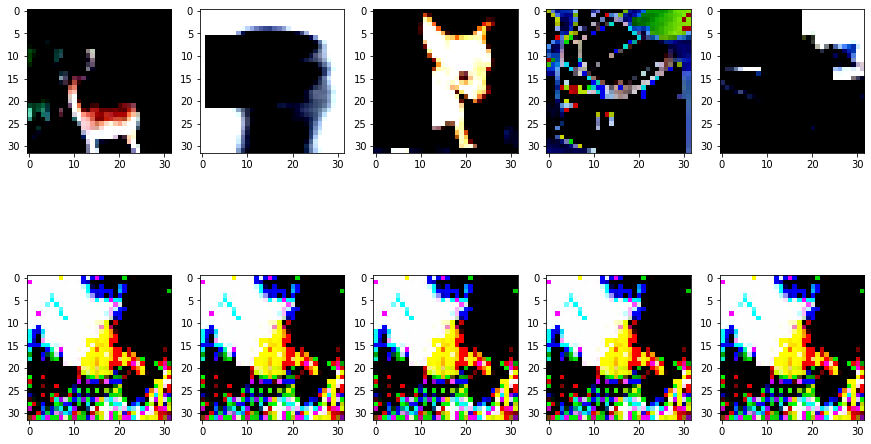

In [90]:
x = torch.randn(256, 3, 32, 32)
for i in range(256):
    x[i] = aug_image_list[i]
x = x.to(device)

z_out_real = E_update(x.to(device))
imges_reconstract = G_update(z_out_real)

loss, loss_each, residual_loss_each, discrimination_loss_each = Anomaly_score(x, imges_reconstract, z_out_real, D_update, Lambda=0.1)
loss_each = loss_each.cpu().detach().numpy()
print("total loss:", np.round(loss_each, 0))
print("discrimination loss:", np.round(discrimination_loss_each.cpu().detach().numpy(), 0))
print(np.shape(x[1].cpu().detach().numpy().transpose(1, 2, 0)))
print(np.shape(imges_reconstract[0].cpu().detach().numpy().transpose(1,2,0)))
tmp = np.where(discrimination_loss_each.cpu().detach().numpy() > 350)

fig = plt.figure(figsize=(15, 9))
for i in range(0,5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[tmp[0][i+5]].cpu().detach().numpy().transpose(1,2,0))
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i].cpu().detach().numpy().transpose(1,2,0))
    #plt.imshow(imges_reconstract[tmp[0][i]].cpu().detach().numpy().transpose(1,2,0))
    plt.savefig("shippai.png")

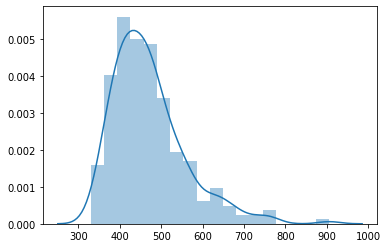

In [91]:
sns.distplot(discrimination_loss_each.cpu().detach().numpy(), rug=False);
#とりあえず閾値を350にしてみる.

In [1515]:
###ここから下は実行しない###
ori_images = data[]["images"].copy()
image_idx = np.arange(len(ori_images))
np.random.shuffle(image_idx)
ori_images = ori_images[image_idx]
ori_images = ori_images / 255.0
mean, std = [0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]
ori_images = (ori_images - mean) / std
aug_policies = found_policies.randaug_policies()
example_list = []
i, j = 0, 0
for image in ori_images:
    chosen_policy = aug_policies[np.random.choice(len(aug_policies))]
    aug_image = augmentation_transforms.apply_policy(chosen_policy, image)
    aug_image = augmentation_transforms.cutout_numpy(aug_image)
    example = tf.train.Example(features=tf.train.Features(
        feature={
            "ori_image": _float_feature(image.reshape(-1)),
            "aug_image": _float_feature(aug_image.reshape(-1)),
        }))
    example_list += [example]
    aug_image_list[i] = torch.from_numpy(aug_image.transpose(2, 0, 1))
    i += 1
    if i >= 256:
        x = aug_image_list
        x = x.to(device)
        z = torch.randn(256, 128).to(device)
        z = z.view(z.size(0), z.size(1), 1, 1)
        z.requires_grad = True
        z_optimizer = torch.optim.Adam([z], lr=1e-3)
        for epoch in range(5000+1):
            fake_img = G_update(z)
            loss, _, discrimination_loss = Anormaly_score(x, fake_img, D_update, Lambda=0.1)
            z_optimizer.zero_grad()
            loss.backward()
            z_optimizer.step()
        fake_img = G_update(z)
        loss, loss_each, residual_loss_each, discrimination_loss = Anormaly_score(x, fake_img, D_update, Lambda=0.1)
        discrimination_loss = discrimination_loss.cpu().detach().numpy()
        print("total loss：", np.round(discrimination_loss, 0))
        tmp = np.where(discrimination_loss > 1000)[0]
        # 1000を超えるdiscrimination lossのところは作り直し.
        for k in range(len(tmp)):
            chosen_policy = aug_policies[np.random.choice(len(aug_policies))]
            image = ori_images[tmp[k] + 256*j]
            aug_image_v2 = augmentation_transforms.apply_policy(chosen_policy, image)
            aug_image_v2 = augmentation_transforms.cutout_numpy(aug_image_v2)
            example = tf.train.Example(features=tf.train.Features(
                feature={
                    "ori_image": _float_feature(image.reshape(-1)),
                    "aug_image": _float_feature(aug_image_v2.reshape(-1)),
                }))
            example_list[tmp[k] + 256*j] = example
        i = 0
        j += 1
        print(len(example_list))
    else:
        pass
out_path = os.path.join(output_base_dir, format_unsup_filename(aug_copy_num),)
save_tfrecord(example_list, out_path)

SyntaxError: invalid syntax (<ipython-input-1515-1e1b1007ccc5>, line 2)